- Assess if temperature data can be predicted based on population data (and maybe other external input such as land cover type).

Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import rasterio as rio
import functions as f
import xarray as xr
from importlib import reload
import os
from tqdm import tqdm

## Data description


#### Enact 2011 Population Grid
Datas of population: Monthly, 1000x1000m, European

#### UrbClim models: 
Monthly dataset, with hourly datas, 100x100m, Cities 
Air Temperature, Relative humidity, Specific humidity, Wind speed

Yearly dataset, 100x100m, Cities
Land-sea mask, Rural-urban mask

## Importing data

In [2]:
#Defining parameters

folder_path = 'data_UHI'
cities = ['Lyon']
number_of_sample_per_city = 100000


In [53]:
#Loading the moduke functions
reload(f)

#Loading data for Lyon
city_df = pd.DataFrame(columns=['temp', 'pop', 'deltaT', 'hour','isrural', 'city', 'landcover'])
for city in cities:
    for month in tqdm(range(1,13)):
        #Open the datasets
        if month < 10:
            str_month = '0'+str(month)
        
        #Setting paths
        temp_file_path = folder_path + '/tas_'+ city +'_UrbClim_2011_'+ str_month +'_v1.0.nc'
        rural_mask_file_path = folder_path +'/ruralurbanmask_'+city +'_UrbClim_v1.0.nc'

        #Open the datasets
        pop_day = rio.open(folder_path + f'/ENACT_POP_D{str_month}2011_EU28_R2020A_4326_30ss_V1_0.tif')
        pop_night = rio.open(folder_path + f'/ENACT_POP_N{str_month}2011_EU28_R2020A_4326_30ss_V1_0.tif')
        rural_mask_file = xr.open_dataset(rural_mask_file_path)
        temp_file = xr.open_dataset(temp_file_path)
        land_cover = rio.open(folder_path + '/MCD12Q1.061_LC_Prop1_doy2011001_aid0001.tif')

        #Crop and resample the datasets
        cropped_pop_day, cropped_pop_night, temp_file_red= f.crop_and_downgrade(pop_day, pop_night, temp_file)
        pop_day_city = f.resample_image(cropped_pop_day, temp_file.tas[0,:,:].shape)
        pop_night_city = f.resample_image(cropped_pop_night, temp_file.tas[0,:,:].shape)
        populations = np.concatenate([np.tile(pop_night_city.flatten(),8), np.tile(pop_day_city.flatten(), 12), np.tile(pop_night_city.flatten(), 4)])
        populations = np.tile(populations, 31)
        
        lc_city = f.crop_image(land_cover, temp_file)
        lc_city = f.resample_image(lc_city, temp_file.tas[0,:,:].shape)
        lc_flatten = np.tile(lc_city.flatten(), temp_file.tas.shape[0])

        latitude = np.tile(temp_file.latitude.values.flatten(), temp_file.tas.shape[0])
        longitude = np.tile(temp_file.longitude.values.flatten(), temp_file.tas.shape[0])

        day_hours = np.tile(np.arange(0,24), temp_file.x.shape[0]*temp_file.y.shape[0])
        hours = np.tile(day_hours.reshape(temp_file.x.shape[0]*temp_file.y.shape[0], 24).flatten(order='F'), 31)

        deltaT = f.compute_deltaT_urban(temp_file, rural_mask_file)
        rural = np.tile(rural_mask_file.ruralurbanmask.values.flatten(), temp_file.tas.shape[0])
        city_data = np.tile(np.array([city]), number_of_sample_per_city)

        #generate random indexes to sample the data
        indexes = np.random.randint(0, temp_file.tas.shape[0]*temp_file.tas.shape[1]*temp_file.tas.shape[2], number_of_sample_per_city)
        city_df = pd.concat([city_df, pd.DataFrame({'temp': temp_file.tas.values.flatten()[indexes],
                                                    'pop':populations[indexes], 
                                                    'deltaT': deltaT[indexes],
                                                    'hour': hours[indexes],
                                                    'isrural' : rural[indexes],
                                                    'landcover':lc_flatten[indexes],
                                                    'city' : city_data})])


  0%|          | 0/12 [00:00<?, ?it/s]C:\Users\broth\AppData\Local\Temp\ipykernel_1604\134542018.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  city_df = pd.concat([city_df, pd.DataFrame({'temp': temp_file.tas.values.flatten()[indexes],
100%|██████████| 12/12 [02:30<00:00, 12.54s/it]


## Importing data file with several citys

In [3]:
#read csv
city_df = pd.read_csv('data_UHI/city_df.csv')
city_df.dropna(inplace=True)
city_df

,Unnamed: 0,temp,pop,wind,hum,deltaT,hour,month,elevation,city,land cover type,NDVI,isrural,latitude,pop_cat
0,0,281.45820,173.245821,2.578628,91.793300,-0.197296,8,1,0.0,Amsterdam,22.0,0.692,1.0,52.377956,1
1,1,277.59088,1227.491137,1.953275,84.101190,1.419159,6,1,1.0,Amsterdam,22.0,0.616,0.0,52.377956,2
2,2,273.18600,1.752613,5.365040,90.277060,0.115814,20,1,-1.0,Amsterdam,22.0,0.852,1.0,52.377956,0
3,3,277.83900,10.464526,3.113809,73.838870,0.302155,14,1,-1.0,Amsterdam,31.0,0.848,0.0,52.377956,0
4,4,273.96704,5172.893327,2.953496,82.726715,1.439209,7,1,6.0,Amsterdam,1.0,0.416,0.0,52.377956,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2120876,39101,280.48407,714.744684,1.391384,62.377445,2.148163,4,12,155.0,Vienna,31.0,0.552,1.0,48.208174,1
2120877,39102,279.47736,61.740572,3.439714,64.843820,1.854706,8,12,158.0,Vienna,32.0,0.500,0.0,48.208174,0
2120878,39103,271.95370,282.486265,0.401704,94.167250,-0.042053,3,12,151.0,Vienna,31.0,0.620,1.0,48.208174,1
2120879,39104,279.80844,895.581379,3.410964,67.637910,1.015381,10,12,153.0,Vienna,31.0,0.524,0.0,48.208174,1


## Data Approach

We split the data between different population to obtain a first overview of the correlation of the heat islands phenomena and the population amount. 

In [4]:
df_sample = city_df
#df_sample = city_df[city_df['city'] == 'Vienna']

df_5000 = df_sample[df_sample['pop'] > 5000]

df_2500 = df_sample[df_sample['pop'] < 5000]
df_2500 = df_2500[df_2500['pop'] > 2500]

df_1000 = df_sample[df_sample['pop'] < 2500]
df_1000 = df_1000[df_1000['pop'] > 1000]

df_0 = df_sample[df_sample['pop'] < 1000]
df_0 = df_0[df_0['pop'] > 0]


dfs = [df_sample, df_5000, df_2500, df_1000, df_0]

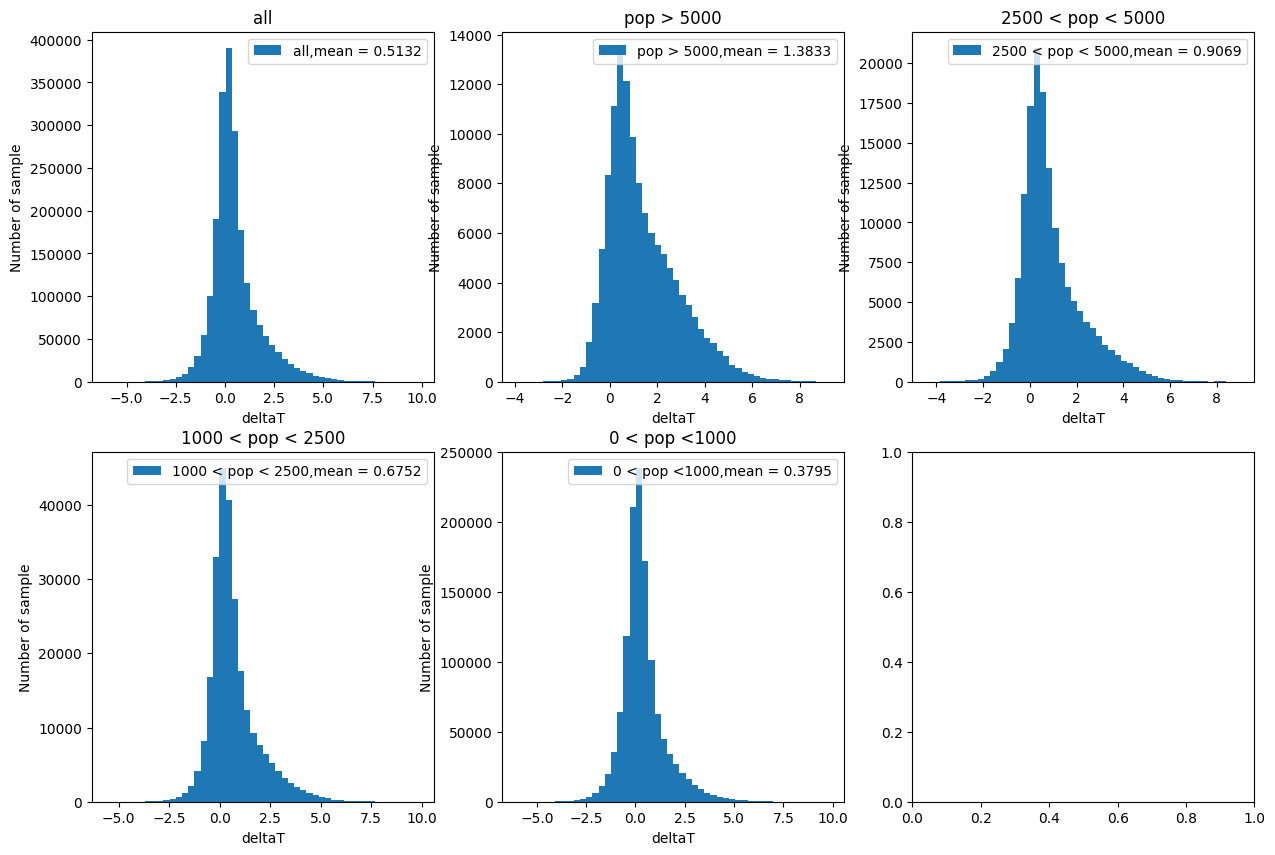

In [107]:
#plot histogram of delta T for all the dataframes with 2 side by side plots
df_legends =   ['all','pop > 5000', '2500 < pop < 5000', '1000 < pop < 2500','0 < pop <1000']
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()
for i, df in enumerate(dfs):
    axs[i].hist(df['deltaT'], bins=50, label = df_legends[i] + f',mean = {df["deltaT"].mean():.4f}')
    axs[i].set_title(df_legends[i])
    axs[i].legend()
    axs[i].set_xlabel('deltaT')
    axs[i].set_ylabel('Number of sample')

## Machine Learning methods

The features on which the analysis is carried upon with are here: temperature, heat islands phenomena, land cover type, NDVI, elevation and latitude.
We restrict the analysis to the urban zone, by choosing only features with 'isrural' == 1.

The data is split between train, test and validation set. 
The data is then scaled. 

The analysis aims at identifying the population based on attributes such as heat islands (namely 'deltaT') and Land Cover. 

In [5]:
# Importing the modules
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import HistGradientBoostingRegressor


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [6]:
scaler = StandardScaler()
df = dfs[0]
df = df[df['isrural'] == 1]

y = df['pop']
X = df.loc[:,  ['temp', 'deltaT', 'land cover type', 'NDVI', 'elevation', 'latitude']]
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

#split the data in training, test, validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

X_train

,temp,deltaT,land cover type,NDVI,elevation,latitude
377006,0.415663,-0.180939,0.787604,-1.853578,1.871027,-1.508353
141478,1.353662,-0.303706,-0.379080,0.683978,-1.024261,0.666204
808158,-1.024695,-0.794531,0.787604,0.188845,-0.309375,-0.091867
254525,-0.775262,0.181725,-0.379080,-0.925204,1.978260,-1.508353
329168,3.232380,0.137671,2.343181,-0.306288,1.308055,-1.508353
...,...,...,...,...,...,...
172105,0.562018,0.574663,0.787604,1.096588,-1.024261,0.666204
653471,0.615718,-0.065271,0.787604,0.415781,0.213386,-0.536213
597572,1.080394,0.363405,-0.379080,-0.079352,0.253598,-0.536213
826455,-1.202428,0.362883,0.787604,0.023801,-0.345119,-0.091867


Different algorithms are tried. The most efficient is the GradientBoostingRegressor() algorithm. 

In [109]:
methods = [LinearRegression(), Ridge(), MLPRegressor(hidden_layer_sizes=(10, 10, 10), max_iter=1000, activation='relu', solver='adam', random_state=42), GradientBoostingRegressor(n_estimators=100, max_depth=10, random_state=42)]
r2s = []
MSEs = []
for method in methods: 
    method.fit(X_train, y_train)
    y_pred = method.predict(X_test)
    print(method)
    print("MSE: ", mean_squared_error(y_test, y_pred))
    print("R2: ", r2_score(y_test, y_pred))
    MSEs.append(mean_squared_error(y_test, y_pred))
    r2s.append(r2_score(y_test, y_pred))

LinearRegression()
MSE:  1471024.4326733088
R2:  0.11181187169798024
Ridge()
MSE:  1471024.428543782
R2:  0.11181187419134231


C:\Users\broth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPRegressor(hidden_layer_sizes=(10, 10, 10), max_iter=1000, random_state=42)
MSE:  1400051.5832313134
R2:  0.1546644857715539


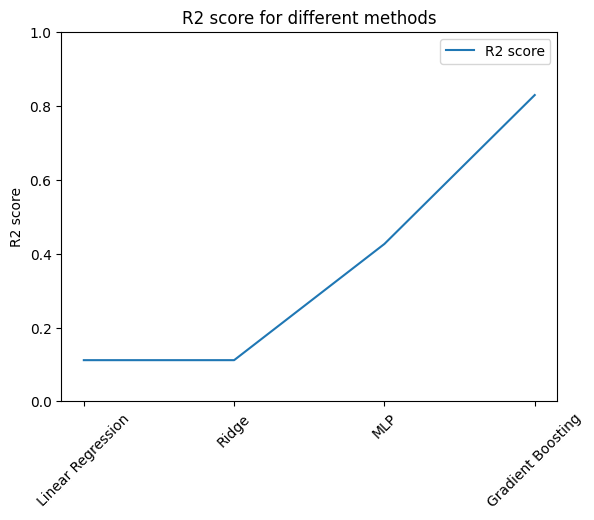

In [12]:
plt.plot(r2s, label = 'R2 score')
plt.ylabel('R2 score')
plt.ylim(0, 1)
plt.xticks(np.arange(4), ('Linear Regression', 'Ridge', 'MLP', 'Gradient Boosting'), rotation = 45)

plt.legend()

plt.title('R2 score for different methods')
plt.show()

In [7]:
method = GradientBoostingRegressor(n_estimators=100, max_depth=10, random_state=42)
method.fit(X_train, y_train)
y_pred = method.predict(X_test)
print(method)
print("MSE: ", mean_squared_error(y_test, y_pred))
print("R2: ", r2_score(y_test, y_pred))

GradientBoostingRegressor(max_depth=10, random_state=42)
MSE:  292449.4159888592
R2:  0.8248714760279898


When working with the dataset with all the cities, we get 0.82 of R2-score, but the most important features are by far elevation, land cover type and NDVI. 


In [9]:
#Identify which features are the most important for a model 
from sklearn.inspection import permutation_importance
importances = permutation_importance(method, X_val, y_val)
# Order the features by importance 
sorted_idx = importances.importances_mean.argsort()[::-1]
X_train.columns[sorted_idx]

Index(['elevation', 'land cover type', 'NDVI', 'latitude', 'deltaT', 'temp'], dtype='object')

If we now try to training on different cities,

In [13]:
cities = df['city'].unique()
for city in cities:
    df_city = df[df['city'] == city]
    df_city = df_city[df_city['isrural'] == 1]
    y = df_city['pop']
    X = df_city.loc[:,  ['temp', 'deltaT', 'land cover type', 'NDVI', 'elevation', 'latitude']]
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    #split the data in training, test, validation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

    method = GradientBoostingRegressor(n_estimators=100, max_depth=10, random_state=42)
    method.fit(X_train, y_train)
    y_pred = method.predict(X_test)
    print(city)
    print("MSE: ", mean_squared_error(y_test, y_pred))
    print("R2: ", r2_score(y_test, y_pred))

    importances = permutation_importance(method, X_val, y_val)
    # Order the features by importance 
    sorted_idx = importances.importances_mean.argsort()[::-1]
    print(X_train.columns[sorted_idx])

Amsterdam
MSE:  348098.33219442476
R2:  0.6114976228072171
Index(['NDVI', 'elevation', 'land cover type', 'deltaT', 'temp', 'latitude'], dtype='object')
Madrid
MSE:  535734.3687540183
R2:  0.9202029227383339
Index(['land cover type', 'elevation', 'NDVI', 'deltaT', 'temp', 'latitude'], dtype='object')
Stockholm
MSE:  149932.58683968845
R2:  0.8117165449719672
Index(['NDVI', 'elevation', 'land cover type', 'deltaT', 'temp', 'latitude'], dtype='object')
Lyon
MSE:  69088.93734612735
R2:  0.8334256511198165
Index(['elevation', 'NDVI', 'land cover type', 'deltaT', 'temp', 'latitude'], dtype='object')
Vienna
MSE:  127545.83650259054
R2:  0.7814438768225117
Index(['NDVI', 'elevation', 'land cover type', 'deltaT', 'temp', 'latitude'], dtype='object')


C:\Users\broth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\broth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\broth\AppData\Local\Temp\ipykernel_15836\3196252130.py:9: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.log10(y_test), np.log10(y_pred), alpha = .1)


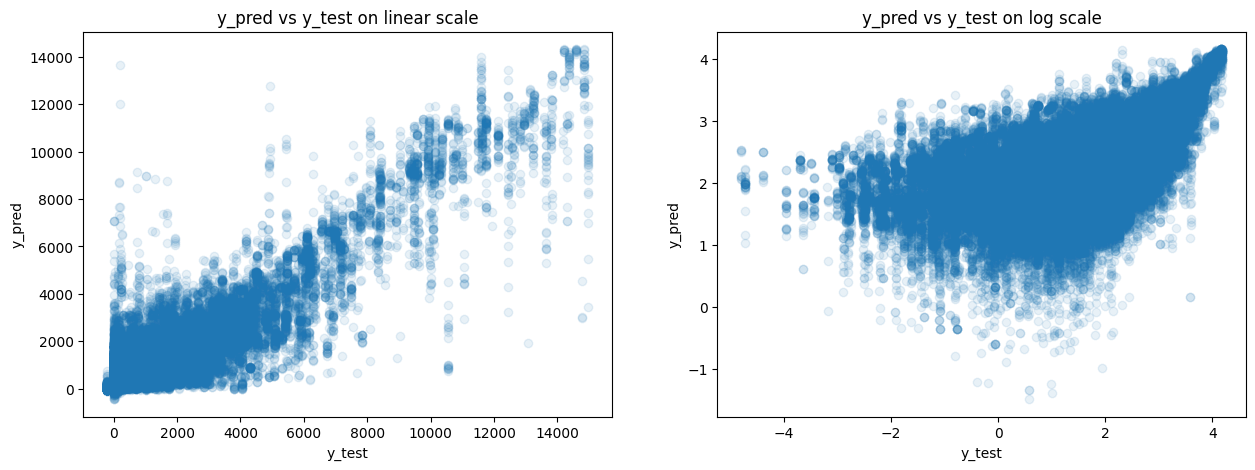

In [15]:
#plot y_pred vs y_test with density once on log scale and once on linear scale on 2 plots side by side
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha = 0.1)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title('y_pred vs y_test on linear scale')
plt.subplot(1, 2, 2)
plt.scatter(np.log10(y_test), np.log10(y_pred), alpha = .1)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title('y_pred vs y_test on log scale')
plt.show()


The algorithm still needs to be fine-tuned to optimize the results, but we already obtained an approximation of the population which is quite satisfying.

In [24]:
# best algortihm is the gradient boosting regressor 
# we will now try to finetune the hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 150, num = 10)]
# Number of features to consider at every split
max_features = np.linspace(0.1, 1, num = 10)
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': sp_randint(10, 150),
               'max_features': [ 'sqrt', 'log2'],
               'max_depth': sp_randint(5, 100),
               'min_samples_split': sp_randint(2, 20),
               'min_samples_leaf': sp_randint(1, 8)}
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = HistGradientBoostingRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 50 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter =50 , cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_val, y_val)
rf_random.best_params_


Fitting 3 folds for each of 50 candidates, totalling 150 fits


KeyboardInterrupt: 